# Fraud: A how-to guide

Using an anonymized set of personal banking transactions, I see if I can generate a month of fictitious transactional operations that wouldn't tip off a forensic accountant. 

In [ ]:
%matplotlib inline

In [591]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from sklearn.neighbors.kde import KernelDensity
import matplotlib.gridspec as gridspec
from __future__ import division

Here's how the data comes in:

In [165]:
df = pd.read_csv('anonymized.csv')
df.head(4)

,Date,Amount
0,25May2016,54241.35
1,29May2017,54008.83
2,30Jun2017,54008.82
3,05Jan2017,52704.37


### Transaction data preprocessing

I'll make a bunch of new columns we can use.

In [323]:
df['rendered_date'] = pd.to_datetime(df['Date'], 
                                     errors = 'coerce', 
                                     format ='%d%b%Y')

df['day'] = df['rendered_date'].dt.day
df['month'] = df['rendered_date'].dt.month
df['month_year'] = df['rendered_date'].map(lambda x: (x.month, x.year))
df['year'] = df['rendered_date'].dt.year

df['day_of_week'] = [date(row.year, row.month, row.day).weekday() 
                                       for row in df.itertuples()]
df.head(3)

,Date,Amount,rendered_date,day,month,month_year,year,day_of_week
0,25May2016,54241.35,2016-05-25,25,5,"(5, 2016)",2016,2
1,29May2017,54008.83,2017-05-29,29,5,"(5, 2017)",2017,0
2,30Jun2017,54008.82,2017-06-30,30,6,"(6, 2017)",2017,4


In [386]:
print("Largest deposit: %.2f" % max(df.Amount))
print("Largest withdrawal: %.2f" % min(df.Amount))
print("Median transaction: %.2f" % np.median(df.Amount))
print("25th percentile: %.2f" % np.percentile(df.Amount, 25))
print("75th percentile: %.2f" % np.percentile(df.Amount, 75))

Largest deposit: 54241.35
Largest withdrawal: -41054.95
Median transaction: -260.00
25th percentile: -890.75
75th percentile: -61.92


Our victim is inclined towards withdrawals — good for us. But the deposit amounts are really untidy: there's a huuuuge range, with the most mass tucked between pretty narrow bounds (the 25th and 75th percentiles are very close to the medians, whereas the max and min are orders of magnitude away in both directions). We'll have to transform this variable: I'll take the log.

In [455]:
# Shift amounts to natural numbers
positive_transformation = min(df.Amount) - 1.0
df['log_amount'] = df.Amount - positive_transformation

# Take log of positive-shifted amounts
df['log_amount'] = np.log(df.log_amount)
df['log_amount'] = df.log_amount.replace(0, None).dropna()
df.head()

,Date,Amount,rendered_date,day,month,month_year,year,day_of_week,log_amount
0,25May2016,54241.35,2016-05-25,25,5,"(5, 2016)",2016,2,11.464757
1,29May2017,54008.83,2017-05-29,29,5,"(5, 2017)",2017,0,11.462314
2,30Jun2017,54008.82,2017-06-30,30,6,"(6, 2017)",2017,4,11.462314
3,05Jan2017,52704.37,2017-01-05,5,1,"(1, 2017)",2017,3,11.448497
4,23Feb2017,52704.36,2017-02-23,23,2,"(2, 2017)",2017,3,11.448497


### Density Modeling

In [486]:
FIGSIZE = (10, 8)

def make_density(series, title, bins, bw, loc): 
    '''Fit kernel density and make plot.'''
    
    data = series.values.reshape(-1, 1)
    
    kde = KernelDensity(kernel='gaussian', bandwidth=bw)
    kde.fit(data)

    all_x = np.linspace(min(data), max(data), 100).reshape((-1, 1))
    density = np.exp(kde.score_samples(all_x))

    axes = series.hist(bins=bins, 
                       normed=True, 
                       figsize=FIGSIZE, 
                       alpha=0.5,
                       edgecolor="r", 
                       linewidth=1,
                       fc='#AAAAFF',
                       ax=loc)
    
    axes.plot(all_x, density, 
              color='g', 
              label='Density')
    
    plt.legend(fontsize=12)
    plt.xlabel(title, size=12)
    plt.ylabel('Frequency', size=12)
    plt.title(title)
    
    return kde

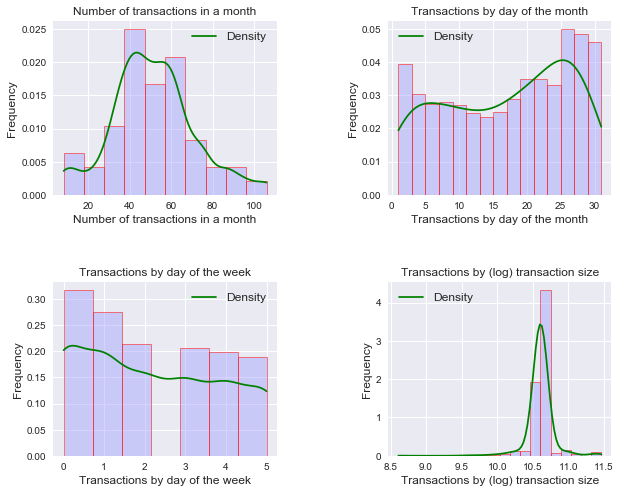

In [487]:
plt.figure(figsize=(2, 2))
gs = gridspec.GridSpec(2, 2, wspace=0.5, hspace=0.5)

mon = df.groupby(['month_year'], as_index=False).count()

by_month = make_density(mon.iloc[:,1], 
                        "Number of transactions in a month", 
                        bins=10,
                        bw=5,
                        loc=plt.subplot(gs[0, 0]))

day_month = make_density(df.day, 
                         "Transactions by day of the month", 
                         bins=15,
                         bw=3,
                         loc=plt.subplot(gs[0, 1]))

day_week = make_density(df.day_of_week,
                        "Transactions by day of the week",
                        bins=7,
                        bw=.5,
                        loc=plt.subplot(gs[1, 0]))

size = make_density(df.log_amount,
                    "Transactions by (log) transaction size",
                    bins=20,
                    bw=0.1,
                    loc=plt.subplot(gs[1, 1]))

The histogram for transactions by day of the week is funny: there are seven days of the week, but one bin is missing. Sure enough...

In [464]:
df.groupby('day_of_week', as_index=False).count()[['day_of_week', 'Amount']]

,day_of_week,Amount
0,0,571
1,1,495
2,2,384
3,3,370
4,4,356
5,5,342


Only six days of the week have transaction counts — nothing on Sunday (which would be day 6)! Bank's closed. 

### Transaction simulation

TIME TO COMMIT THE CRIME!

In [606]:
transaction_num = int(by_month.sample())
days_of_crime = np.clip(sorted(day_month.sample(transaction_num)), 1, 31)
amounts = np.exp(size.sample(transaction_num)) + positive_transformation

crimes = zip([int(d) for d in days_of_crime], amounts)

print("In our month of crime, we'll make %0.f fraudulent transactions:" 
      % transaction_num)

for date, amount in crimes:
    print("\t Day %.f, transact %.2f USD" %
            (date, amount))

In our month of crime, we'll make 66 fraudulent transactions:
	 Day 1, transact 1939.86 USD
	 Day 1, transact 2797.35 USD
	 Day 1, transact -5200.40 USD
	 Day 1, transact -5428.08 USD
	 Day 1, transact 16970.15 USD
	 Day 1, transact -951.61 USD
	 Day 1, transact -7617.50 USD
	 Day 2, transact 2901.08 USD
	 Day 2, transact 7874.21 USD
	 Day 2, transact -133.29 USD
	 Day 3, transact 3767.68 USD
	 Day 4, transact 2037.57 USD
	 Day 4, transact -5273.23 USD
	 Day 4, transact -2985.82 USD
	 Day 5, transact 871.51 USD
	 Day 6, transact 10015.91 USD
	 Day 7, transact 837.48 USD
	 Day 8, transact -3897.51 USD
	 Day 9, transact -15629.61 USD
	 Day 9, transact 4253.71 USD
	 Day 9, transact 22217.46 USD
	 Day 11, transact 1358.65 USD
	 Day 12, transact 12757.65 USD
	 Day 12, transact -3330.91 USD
	 Day 12, transact -11330.12 USD
	 Day 12, transact -2843.61 USD
	 Day 12, transact -7854.34 USD
	 Day 13, transact -735.58 USD
	 Day 15, transact -4217.03 USD
	 Day 16, transact -1855.50 USD
	 Day 16, tr

Outstanding weaknesses in this model: 
- The kernel density estimator occasionally extrapolates, assuming an unrealistic support. For example, sometimes samples from the day-of-month kernel density estimate are negative (barely — rarely lower than -5, if anything) or greater than 31. I band-aided over this by clipping off any samples < 0 or > 31. Obviously, there isn't a -2nd or 33rd day of any month.
- It's having me make deposits a good amount of the time. Perhaps that makes me a very subtle criminal, but I don't think a very standard one.
- It assumes that these variables are independent! They are certainly not. As we know, the day of week — not merely the day of month — is a consequential variable, and these aren't independent. At present, I can only sample from one of these distributions at a time (above, we see day-of-month samples). But furthermore, above we see multiple transactions on the same day. As evidenced in the following cell, perhaps this isn't unheard of, but more than 2 per day — and perhaps for multiple days in a row — could be rather suspicious.

In [607]:
multiple_trans = df.groupby('Date', as_index=False).count().iloc[:,1]

print("Max. transactions in one day: %.f" % max(multiple_trans))
print("Median transactions in one day: %.f" % 
      np.percentile(multiple_trans, 50))

Max. transactions in one day: 15
Median transactions in one day: 2


- We do see, however, that even this one sample seems to adhere to Benford's law relatively well (at least for the first three digits). On average, I'd imagine we'd see strong adherence:

In [610]:
for digit in range(1, 10):
    
    starting_dig = sum([1 for a in amounts.reshape(amounts.shape[0],) 
                            if str(abs(a))[0] == str(digit)])
    
    print("%.3f percent of sampled transactions amounts start with digit %.f" %
             (starting_dig / len(amounts), digit))


0.333 percent of sampled transactions amounts start with digit 1
0.167 percent of sampled transactions amounts start with digit 2
0.106 percent of sampled transactions amounts start with digit 3
0.061 percent of sampled transactions amounts start with digit 4
0.121 percent of sampled transactions amounts start with digit 5
0.015 percent of sampled transactions amounts start with digit 6
0.076 percent of sampled transactions amounts start with digit 7
0.061 percent of sampled transactions amounts start with digit 8
0.061 percent of sampled transactions amounts start with digit 9
